# Federated Learning com Flower + DLG Attack

Este notebook implementa:
1. Federated Learning usando Flower
2. Ataque DLG (Deep Leakage from Gradients) para demonstrar vulnerabilidades de privacidade

## Instalação de Dependências

In [1]:
!pip install -q flwr==1.9.0 "flwr[simulation]"
!pip install -q tensorflow numpy matplotlib

In [1]:
import tensorflow as tf
import flwr as fl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner

# Imports do Flower para servidor
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters
from flwr.common import FitIns, EvaluateIns
from flwr.server.strategy.aggregate import aggregate

# Importar utils
import utils

print("✓ Imports completos")

2025-11-13 08:05:04.438953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/diegomonego/Documents/Mestrado/Cadeiras/MO809/TF-MO809-copy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-13 08:05:12,153	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Usando o dispositivo: cpu
✓ Imports completos


In [2]:
class GradientQuantizer:
    def __init__(self, num_bits=8):
        self.num_bits = num_bits
        self.num_levels = 2 ** num_bits
        
    def quantize_gradients(self, gradients):
        """Quantiza com escala GLOBAL (não por tensor)"""
        quantized_grads = []
        
        # Encontrar min/max global de TODOS os tensores
        all_values = torch.cat([g.flatten() for g in gradients if g is not None])
        global_min = all_values.min().item()
        global_max = all_values.max().item()
        
        scale = (global_max - global_min) / (self.num_levels - 1)
        
        if scale == 0:
            scale = 1.0  # Evitar divisão por zero
        
        for grad in gradients:
            if grad is None:
                quantized_grads.append(None)
                continue
            
            # Quantizar usando escala global
            quantized = torch.round((grad - global_min) / scale)
            quantized = torch.clamp(quantized, 0, self.num_levels - 1)
            
            dtype = torch.uint8 if self.num_bits <= 8 else torch.int16
            quantized_grads.append(quantized.to(dtype))
        
        # Metadata simplificada: apenas min/max global
        metadata = {'min': global_min, 'max': global_max, 'num_bits': self.num_bits}
        
        return quantized_grads, metadata
    
    def dequantize_gradients(self, quantized_grads, metadata):
        """Dequantiza usando escala global"""
        dequantized_grads = []
        
        global_min = metadata['min']
        global_max = metadata['max']
        scale = (global_max - global_min) / (self.num_levels - 1)
        
        for quant_grad in quantized_grads:
            if quant_grad is None:
                dequantized_grads.append(None)
                continue
            
            # Dequantizar
            dequant = quant_grad.float() * scale + global_min
            dequantized_grads.append(dequant)
        
        return dequantized_grads
    
    def aggregate_quantized(self, quantized_grads_list, weights_list):
        """Agrega pesos quantizados"""
        if not quantized_grads_list:
            return []
        
        total_weight = sum(weights_list)
        num_params = len(quantized_grads_list[0])
        aggregated = []
        
        for param_idx in range(num_params):
            weighted_sum = None
            
            for client_grads, weight in zip(quantized_grads_list, weights_list):
                if param_idx >= len(client_grads):
                    continue
                    
                grad = client_grads[param_idx]
                if grad is None:
                    continue
                
                grad_float = grad.float() * (weight / total_weight)
                
                if weighted_sum is None:
                    weighted_sum = grad_float
                else:
                    weighted_sum += grad_float
            
            if weighted_sum is not None:
                aggregated_quantized = torch.round(weighted_sum)
                dtype = torch.uint8 if self.num_bits <= 8 else torch.int16
                aggregated.append(aggregated_quantized.clamp(0, self.num_levels-1).to(dtype))
            else:
                aggregated.append(None)
        
        return aggregated
    
    def compress_ratio(self):
        return 32 / self.num_bits

## Código Cliente

In [3]:
class ClienteComQuantizacao(fl.client.NumPyClient):
    def __init__(self, cid, niid, num_clients, dirichlet_alpha, quantizer=None):
        self.cid = int(cid)
        self.niid = niid
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha
        self.quantizer = quantizer
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load data
        self.x_train, self.y_train, self.x_test, self.y_test = self.load_data()
        
        # Create model
        self.model = self.create_model()
        self.model.to(self.device)

    def get_parameters(self, config):
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def load_data(self):
        if self.niid:
            partitioner_train = DirichletPartitioner(
                num_partitions=self.num_clients, 
                partition_by="label",
                alpha=self.dirichlet_alpha, 
                min_partition_size=0,
                self_balancing=False
            )
            partitioner_test = DirichletPartitioner(
                num_partitions=self.num_clients, 
                partition_by="label",
                alpha=self.dirichlet_alpha, 
                min_partition_size=0,
                self_balancing=False
            )
        else:
            partitioner_train = IidPartitioner(num_partitions=self.num_clients)
            partitioner_test = IidPartitioner(num_partitions=self.num_clients)

        fds = FederatedDataset(dataset='cifar10', partitioners={"train": partitioner_train})
        train = fds.load_partition(self.cid).with_format("numpy")

        fds_eval = FederatedDataset(dataset='cifar10', partitioners={"test": partitioner_test})
        test = fds_eval.load_partition(self.cid).with_format("numpy")

        x_train = train['img'] / 255.0
        x_train = x_train.transpose(0, 3, 1, 2)
        
        x_test = test['img'] / 255.0
        x_test = x_test.transpose(0, 3, 1, 2)

        return x_train.astype(np.float32), train['label'], x_test.astype(np.float32), test['label']

    def create_model(self):
        return utils.cria_modelo('cifar10')

    def set_parameters(self, parameters, config=None):
        """Define pesos do modelo"""
        try:
            print(f"[Cliente {self.cid}] set_parameters recebeu {len(parameters)} arrays")
            
            expected_params = len(list(self.model.state_dict().keys()))
            print(f"[Cliente {self.cid}] Modelo espera {expected_params} parâmetros")
            
            # Reconstruir metadata do config (se disponível)
            metadata = None
            if config is not None and 'quant_min' in config:
                metadata = {
                    'min': config['quant_min'],
                    'max': config['quant_max'],
                    'num_bits': config['quant_bits']
                }
                print(f"[Cliente {self.cid}] Metadata detectada no config")
            
            if metadata is not None and self.quantizer is not None:
                print(f"[Cliente {self.cid}] Dequantizando parâmetros...")
                quantized_params = [torch.from_numpy(p) for p in parameters]
                dequantized_params = self.quantizer.dequantize_gradients(quantized_params, metadata)
                
                params_dict = zip(self.model.state_dict().keys(), dequantized_params)
                state_dict = {k: v for k, v in params_dict}
            else:
                print(f"[Cliente {self.cid}] Carregando parâmetros sem dequantização")
                params_dict = zip(self.model.state_dict().keys(), parameters)
                state_dict = {k: torch.tensor(v) for k, v in params_dict}
            
            self.model.load_state_dict(state_dict, strict=True)
            print(f"[Cliente {self.cid}] Pesos carregados com sucesso")
            
        except Exception as e:
            print(f"❌ [Cliente {self.cid}] ERRO em set_parameters: {type(e).__name__}: {str(e)}")
            import traceback
            traceback.print_exc()
            raise

    def fit(self, parameters, config):
        """Treinamento local com captura de gradientes de UMA ÚNICA IMAGEM"""
        try:
            server_round = config['server_round']
            
            print(f"\n{'='*50}")
            print(f"[Cliente {self.cid}] FIT RODADA {server_round}")
            print(f"  - Recebeu {len(parameters)} parâmetros")
            print(f"{'='*50}\n")
            
            # Configurar pesos
            self.set_parameters(parameters, config)
            
            # SALVAR PESOS INICIAIS
            initial_weights = [p.data.clone().cpu() for p in self.model.parameters()]
            
            self.model.train()
            
            # DataLoader - SHUFFLE FALSE para consistência
            train_dataset = TensorDataset(
                torch.FloatTensor(self.x_train),
                torch.LongTensor(self.y_train)
            )
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
            
            # Optimizer
            optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            
            # Variáveis para captura
            first_image_gradient = None
            first_image_captured = False
            
            # Training loop
            epoch_loss = 0.0
            epoch_acc = 0.0
            num_batches = 0
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # CAPTURAR gradientes da primeira imagem do primeiro batch
                if not first_image_captured:
                    # Calcular gradientes da primeira imagem ANTES do optimizer.step()
                    self.model.zero_grad()
                    single_output = self.model(images[0:1])  # Apenas primeira imagem
                    single_loss = criterion(single_output, labels[0:1])
                    single_loss.backward()
                    
                    # Capturar gradientes
                    first_image_gradient = [p.grad.detach().clone().cpu() for p in self.model.parameters()]
                    first_image_captured = True
                    
                    print(f"[Cliente {self.cid}] Gradientes da primeira imagem capturados!")
                    print(f"   - Label: {labels[0].item()}")
                
                # Treinar normalmente no batch completo
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Metrics
                epoch_loss += loss.item()
                _, predicted = outputs.max(1)
                epoch_acc += predicted.eq(labels).sum().item() / len(labels)
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches
            
            print(f"[Cliente {self.cid}] Treino completo - Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
            
            # ENVIAR: Pesos finais + Pesos iniciais + Gradientes
            if self.quantizer is not None:
                current_weights = [p.data.cpu() for p in self.model.parameters()]
                
                print(f"[Cliente {self.cid}] Quantizando pesos finais...")
                quantized_weights, weight_metadata = self.quantizer.quantize_gradients(current_weights)
                
                print(f"[Cliente {self.cid}] Quantizando pesos iniciais...")
                quantized_initial, initial_metadata = self.quantizer.quantize_gradients(initial_weights)
                
                print(f"[Cliente {self.cid}] Quantizando gradientes...")
                quantized_grads, grad_metadata = self.quantizer.quantize_gradients(first_image_gradient)
                
                params_to_send = [w.cpu().numpy() if w is not None else None 
                                for w in quantized_weights]
                initial_to_send = [w.cpu().numpy() if w is not None else None 
                                for w in quantized_initial]
                grads_to_send = [g.cpu().numpy() if g is not None else None 
                                for g in quantized_grads]
                
                fit_msg = {
                    'cid': self.cid,
                    'accuracy': float(avg_acc),
                    'loss': float(avg_loss),
                    'quantized': True,
                    'quant_min': float(weight_metadata['min']),
                    'quant_max': float(weight_metadata['max']),
                    'quant_bits': int(weight_metadata['num_bits']),
                    'initial_quant_min': float(initial_metadata['min']),
                    'initial_quant_max': float(initial_metadata['max']),
                    'grad_quant_min': float(grad_metadata['min']),
                    'grad_quant_max': float(grad_metadata['max']),
                    'num_weights': len(params_to_send),
                    'num_initial': len(initial_to_send),
                }
                
                combined_params = params_to_send + initial_to_send + grads_to_send
                
            else:
                params_to_send = self.get_parameters(config)
                initial_to_send = [w.numpy() for w in initial_weights]
                grads_to_send = [g.numpy() for g in first_image_gradient]
                
                fit_msg = {
                    'cid': self.cid,
                    'accuracy': float(avg_acc),
                    'loss': float(avg_loss),
                    'quantized': False,
                    'num_weights': len(params_to_send),
                    'num_initial': len(initial_to_send),
                }
                
                combined_params = params_to_send + initial_to_send + grads_to_send

            self.log_client('train.csv', server_round, avg_acc, avg_loss)
            print(f"[Cliente {self.cid}] Retornando {len(combined_params)} parâmetros")

            return combined_params, len(self.x_train), fit_msg
                        
        except Exception as e:
            print(f"\n{'!'*50}")
            print(f"❌ [Cliente {self.cid}] CRASH NO FIT")
            print(f"   Tipo: {type(e).__name__}")
            print(f"   Mensagem: {str(e)}")
            print(f"{'!'*50}\n")
            import traceback
            traceback.print_exc()
            raise
     
                
    def evaluate(self, parameters, config):
        """Avaliação do modelo"""
        self.set_parameters(parameters, config)
        self.model.eval()
        
        test_dataset = TensorDataset(
            torch.FloatTensor(self.x_test),
            torch.LongTensor(self.y_test)
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
        
        criterion = nn.CrossEntropyLoss()
        
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        avg_loss = test_loss / len(test_loader)
        accuracy = correct / total
        
        eval_msg = {
            'cid': self.cid,
            'accuracy': accuracy,
            'loss': avg_loss
        }
        
        self.log_client('evaluate.csv', config['server_round'], accuracy, avg_loss)
        return avg_loss, len(self.x_test), eval_msg

    def log_client(self, file_name, server_round, acc, loss):
        with open(file_name, 'a') as file:
            file.write(f'{server_round}, {self.cid}, {acc}, {loss}\n')

## Código Servidor

In [4]:
class ServidorComQuantizacao(fl.server.strategy.FedAvg):
    def __init__(self, num_clients, dirichlet_alpha, fraction_fit=0.5, quantizer=None):
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha
        self.quantizer = quantizer
        
        # Storage
        self.intercepted_quantized_gradients = {}  # Gradientes de 1 imagem
        self.intercepted_weights = {}  # Pesos finais
        self.intercepted_initial_weights = {}  # Pesos iniciais (NOVO)
        self.intercepted_metadata = {}  # Metadata dos gradientes
        self.intercepted_weight_metadata = {}  # Metadata dos pesos finais
        self.intercepted_initial_metadata = {}  # Metadata dos pesos iniciais (NOVO)
        
        # Armazenar modelo global QUANTIZADO (rodadas 2+)
        self.global_quantized_weights = None
        self.global_metadata = None

        super().__init__(fraction_fit=fraction_fit, min_available_clients=num_clients)

    def configure_fit(self, server_round, parameters, client_manager):
        """Envia pesos para clientes com metadata se quantizado"""
        config = {
            'server_round': server_round,
        }
        
        # Rodadas 2+: enviar metadata como valores separados
        if server_round > 1 and self.global_metadata is not None:
            config['quant_min'] = float(self.global_metadata['min'])
            config['quant_max'] = float(self.global_metadata['max'])
            config['quant_bits'] = int(self.global_metadata['num_bits'])
        
        fit_ins = FitIns(parameters, config)
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        return [(client, fit_ins) for client in clients]

    def aggregate_fit(self, server_round, results, failures):
        """Agregação + interceptação de gradientes e pesos iniciais"""
        print(f"\n[DEBUG] Rodada {server_round}")
        print(f"  - Número de resultados: {len(results)}")
        print(f"  - Falhas: {len(failures)}")
        
        if not results:
            print("⚠️ ERRO: Nenhum resultado recebido dos clientes!")
            raise Exception("Nenhum resultado dos clientes")
        
        quantized_weights_list = []
        weights_list = []
        metadata_list = []
        
        for client_proxy, fit_res in results:
            cid = fit_res.metrics['cid']
            acc = fit_res.metrics['accuracy']
            loss = fit_res.metrics['loss']
            is_quantized = fit_res.metrics.get('quantized', False)
            
            print(f"Rodada {server_round} - Cliente {cid}: Acc={acc:.4f}, Loss={loss:.4f}, Quant={is_quantized}")
            
            parameters = parameters_to_ndarrays(fit_res.parameters)
            num_examples = int(fit_res.num_examples)
            
            # SEPARAR: pesos_finais + pesos_iniciais + gradientes
            num_weights = fit_res.metrics['num_weights']
            num_initial = fit_res.metrics['num_initial']
            
            weight_params = parameters[:num_weights]
            initial_params = parameters[num_weights:num_weights + num_initial]
            gradient_params = parameters[num_weights + num_initial:]
            
            print(f"  - Separados: {len(weight_params)} finais, {len(initial_params)} iniciais, {len(gradient_params)} gradientes")
            
            if is_quantized:
                # Metadata dos pesos finais
                weight_metadata = {
                    'min': fit_res.metrics['quant_min'],
                    'max': fit_res.metrics['quant_max'],
                    'num_bits': fit_res.metrics['quant_bits']
                }
                
                # Metadata dos pesos iniciais
                initial_metadata = {
                    'min': fit_res.metrics['initial_quant_min'],
                    'max': fit_res.metrics['initial_quant_max'],
                    'num_bits': fit_res.metrics['quant_bits']
                }
                
                # Metadata dos gradientes
                grad_metadata = {
                    'min': fit_res.metrics['grad_quant_min'],
                    'max': fit_res.metrics['grad_quant_max'],
                    'num_bits': fit_res.metrics['quant_bits']
                }
                
                # Converter para torch
                quantized_weights = [torch.from_numpy(p) if p is not None else None 
                                   for p in weight_params]
                quantized_initial = [torch.from_numpy(p) if p is not None else None 
                                    for p in initial_params]
                quantized_grads = [torch.from_numpy(p) if p is not None else None 
                                 for p in gradient_params]
                
                # INTERCEPTAR GRADIENTES (para ataque DLG)
                self.intercepted_quantized_gradients[(server_round, cid)] = quantized_grads
                self.intercepted_metadata[(server_round, cid)] = grad_metadata
                
                # INTERCEPTAR PESOS FINAIS
                self.intercepted_weights[(server_round, cid)] = quantized_weights
                self.intercepted_weight_metadata[(server_round, cid)] = weight_metadata
                
                # INTERCEPTAR PESOS INICIAIS (NOVO)
                self.intercepted_initial_weights[(server_round, cid)] = quantized_initial
                self.intercepted_initial_metadata[(server_round, cid)] = initial_metadata
                
                quantized_weights_list.append(quantized_weights)
                metadata_list.append(weight_metadata)
            else:
                # Sem quantização
                weights = [torch.from_numpy(p) for p in weight_params]
                initial = [torch.from_numpy(p) for p in initial_params]
                grads = [torch.from_numpy(p) for p in gradient_params]
                
                # INTERCEPTAR GRADIENTES
                self.intercepted_quantized_gradients[(server_round, cid)] = grads
                self.intercepted_metadata[(server_round, cid)] = None
                
                # INTERCEPTAR PESOS FINAIS
                self.intercepted_weights[(server_round, cid)] = weights
                self.intercepted_weight_metadata[(server_round, cid)] = None
                
                # INTERCEPTAR PESOS INICIAIS (NOVO)
                self.intercepted_initial_weights[(server_round, cid)] = initial
                self.intercepted_initial_metadata[(server_round, cid)] = None
                
                quantized_weights_list.append(weights)
                metadata_list.append(None)
            
            weights_list.append(num_examples)

        # AGREGAÇÃO SEM DEQUANTIZAÇÃO (apenas dos pesos finais)
        if self.quantizer is not None and metadata_list and all(m is not None for m in metadata_list):
            print(f"[Servidor] Agregando {len(quantized_weights_list)} clientes (quantizado)")
            
            if not quantized_weights_list:
                print("⚠️ Nenhum peso quantizado para agregar")
                raise Exception("Todos os clientes falharam")
            
            # Agregar pesos quantizados
            aggregated_quantized = self.quantizer.aggregate_quantized(
                quantized_weights_list, 
                weights_list
            )
            
            if not metadata_list:
                print("⚠️ metadata_list vazia!")
                raise Exception("Nenhuma metadata disponível")
            
            # Usar metadata do primeiro cliente
            self.global_metadata = metadata_list[0]
            
            # Converter para numpy
            agg_parameters = [g.numpy() if g is not None else None 
                             for g in aggregated_quantized]
            
        else:
            print(f"[Servidor] Agregando {len(quantized_weights_list)} clientes (não-quantizado)")
            # Agregação normal
            parameters_list = [[g.numpy() for g in weights] for weights in quantized_weights_list]
            weighted_params = []
            for i in range(len(parameters_list[0])):
                weighted_sum = np.zeros_like(parameters_list[0][i])
                total_weight = sum(weights_list)
                for params, weight in zip(parameters_list, weights_list):
                    weighted_sum += params[i] * (weight / total_weight)
                weighted_params.append(weighted_sum)
            agg_parameters = weighted_params
        
        agg_parameters = ndarrays_to_parameters(agg_parameters)
        return agg_parameters, {}

    def configure_evaluate(self, server_round, parameters, client_manager):
        """Configura avaliação"""
        config = {
            'server_round': server_round,
        }
        
        # Enviar metadata como valores separados
        if server_round > 1 and self.global_metadata is not None:
            config['quant_min'] = float(self.global_metadata['min'])
            config['quant_max'] = float(self.global_metadata['max'])
            config['quant_bits'] = int(self.global_metadata['num_bits'])
        
        evaluate_ins = EvaluateIns(parameters, config)
        
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(self, server_round, results, failures):
        """Agregação de métricas de avaliação"""
        if not results or len(results) == 0:
            print(f"⚠️ Rodada {server_round}: Nenhum resultado de avaliação recebido")
            return 0.0, {}
        
        accuracies = [response.metrics['accuracy'] for _, response in results]
        avg_acc = sum(accuracies) / len(accuracies)
        print(f"Rodada {server_round} acurácia agregada: {avg_acc:.4f}")
        return avg_acc, {}

## Configuração da Simulação

In [ ]:
import warnings
import logging
warnings.filterwarnings("ignore")

# Habilitar logging detalhado para capturar erros do Ray
logging.basicConfig(level=logging.ERROR)

# ========== CONFIGURAÇÃO ==========
NCLIENTS        = 10
NROUNDS         = 10
NIID            = False
DIRICHLET_ALPHA = 0.1
FRACTION_FIT    = 0.5

# ========== QUANTIZAÇÃO ==========
ENABLE_QUANTIZATION = True   # True para habilitar, False para desabilitar
QUANTIZATION_BITS = 8        # 2, 4, 8, 16

# Criar quantizador
if ENABLE_QUANTIZATION:
    quantizer = GradientQuantizer(num_bits=QUANTIZATION_BITS)
    print(f"✓ Quantização habilitada: {QUANTIZATION_BITS} bits ({quantizer.compress_ratio()}x compressão)")
else:
    quantizer = None
    print("✓ Quantização desabilitada (baseline)")

def create_client(cid):
    client = ClienteComQuantizacao(cid, NIID, NCLIENTS, DIRICHLET_ALPHA, quantizer=quantizer)
    return client.to_client()

class Simulation():
    def __init__(self):
        self.server = ServidorComQuantizacao(
            num_clients=NCLIENTS, 
            dirichlet_alpha=DIRICHLET_ALPHA, 
            fraction_fit=FRACTION_FIT,
            quantizer=quantizer
        )

    def run_simulation(self):
        fl.simulation.start_simulation(
            client_fn     = create_client,
            num_clients   = NCLIENTS,
            config        = fl.server.ServerConfig(num_rounds=NROUNDS),
            strategy      = self.server
        )
        return self.server

# Executar simulação com try-except avançado
print(f"\n{'='*60}")
print(f"Iniciando FL com quantização={ENABLE_QUANTIZATION}")
print(f"{'='*60}\n")

servidor = None
try:
    sim = Simulation()
    servidor = sim.run_simulation()
    print("\n✅ Simulação completada com sucesso!")
    
except Exception as e:
    print(f"\n{'='*60}")
    print("❌ SIMULAÇÃO CRASHOU")
    print(f"{'='*60}")
    print(f"Erro: {type(e).__name__}: {str(e)}")
    print(f"{'='*60}")
    
    import traceback
    traceback.print_exc()
    
    # Tentar acessar servidor para ver o que foi capturado
    if 'sim' in locals() and hasattr(sim, 'server'):
        servidor = sim.server
        print(f"\n⚠️ Dados parciais disponíveis:")
        print(f"  - Gradientes interceptados: {len(servidor.intercepted_quantized_gradients)}")
        if servidor.intercepted_quantized_gradients:
            print(f"  - Rodadas disponíveis: {list(servidor.intercepted_quantized_gradients.keys())}")
    
    print(f"\n💡 Dica: Se crashou na rodada 2+, verifique:")
    print(f"   1. Serialização de metadata (torch.Size → list)")
    print(f"   2. Logs de erro dos clientes acima")
    print(f"   3. Tente ENABLE_QUANTIZATION = False para testar baseline")

finally:
    # Sempre mostrar resultado final
    if servidor is not None:
        print(f"\n{'='*60}")
        print(f"Gradientes interceptados: {len(servidor.intercepted_quantized_gradients)} amostras")
        if servidor.intercepted_quantized_gradients:
            print(f"Disponíveis: {list(servidor.intercepted_quantized_gradients.keys())[:5]}...")
        print(f"{'='*60}")
    else:
        print(f"\n⚠️ Nenhum dado foi capturado (crash muito cedo)")

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


✓ Quantização desabilitada (baseline)

Iniciando FL com quantização=False



2025-11-13 08:24:32,626	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 16.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 17291714560.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=38870) 2025-11-13 08:24:41.200193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=38870) To enable the following instructions: AVX2 FMA, in other operations, rebuild

(ClientAppActor pid=38873) Usando o dispositivo: cpu


INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=38871) Usando o dispositivo: cpu
(ClientAppActor pid=38872) Usando o dispositivo: cpu
(ClientAppActor pid=38873) 
(ClientAppActor pid=38873) ==================================================
(ClientAppActor pid=38873) [Cliente 6] FIT RODADA 1
(ClientAppActor pid=38873)   - Recebeu 10 parâmetros
(ClientAppActor pid=38873) ==================================================
(ClientAppActor pid=38873) 
(ClientAppActor pid=38873) [Cliente 6] set_parameters recebeu 10 arrays
(ClientAppActor pid=38873) [Cliente 6] Modelo espera 10 parâmetros
(ClientAppActor pid=38873) [Cliente 6] Carregando parâmetros sem dequantização
(ClientAppActor pid=38873) [Cliente 6] Pesos carregados com sucesso
(ClientAppActor pid=38873) [Cliente 6] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38873)    - Label: 1
(ClientAppActor pid=38873) [Cliente 6] Treino completo - Loss: 2.5199, Acc: 0.1172
(ClientAppActor pid=38873) [Cliente 6] Retornando 30 parâmetros
(ClientAppActor pid=38

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 1
  - Número de resultados: 5
  - Falhas: 0
Rodada 1 - Cliente 4: Acc=0.1216, Loss=2.5327, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 1 - Cliente 0: Acc=0.1190, Loss=2.5310, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 1 - Cliente 6: Acc=0.1172, Loss=2.5199, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 1 - Cliente 3: Acc=0.1218, Loss=2.5344, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 1 - Cliente 8: Acc=0.1238, Loss=2.4592, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38865) Usando o dispositivo: cpu
(ClientAppActor pid=38871) ================================================== [repeated 6x across cluster]
(ClientAppActor pid=38871) [Cliente 0] FIT RODADA 1 [repeated 2x across cluster]
(ClientAppActor pid=38871)   - Recebeu 10 parâmetros [repeated 2x across cluster]
(ClientA

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 1 acurácia agregada: 0.1669
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) ==================================================
(ClientAppActor pid=38865) [Cliente 5] FIT RODADA 2
(ClientAppActor pid=38865)   - Recebeu 10 parâmetros
(ClientAppActor pid=38865) ==================================================
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) [Cliente 5] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38865) [Cliente 5] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38865) [Cliente 5] Carregando parâmetros sem dequantização [repeated 5x across cluster]
(ClientAppActor pid=38865) [Cliente 5] Pesos carregados com sucesso [repeated 5x across cluster]
(ClientAppActor pid=38864) 
(ClientAppActor pid=38864) 
(ClientAppActor pid=38864) [Cliente 1] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38864)    - Label: 4
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) 
(ClientAppAc

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=38865) [Cliente 5] Treino completo - Loss: 2.2021, Acc: 0.1893
(ClientAppActor pid=38865) [Cliente 5] Retornando 30 parâmetros

[DEBUG] Rodada 2
  - Número de resultados: 5
  - Falhas: 0
Rodada 2 - Cliente 5: Acc=0.1893, Loss=2.2021, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 2 - Cliente 9: Acc=0.2026, Loss=2.1749, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 2 - Cliente 1: Acc=0.1887, Loss=2.1867, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 2 - Cliente 8: Acc=0.1903, Loss=2.1831, Quant=False


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 2 - Cliente 6: Acc=0.1919, Loss=2.1963, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38867) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38867) [Cliente 9] FIT RODADA 2 [repeated 4x across cluster]
(ClientAppActor pid=38867)   - Recebeu 10 parâmetros [repeated 4x across cluster]
(ClientAppActor pid=38867) [Cliente 8] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38867) [Cliente 8] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38867) [Cliente 8] Carregando parâmetros sem dequantização [repeated 5x across cluster]
(ClientAppActor pid=38867) [Cliente 8] Pesos carregados com sucesso [repeated 5x across cluster]
(ClientAppActor pid=38867) [Cliente 9] Gradientes da primeira imagem capturados! [repeated 4x across cluster]
(Cli

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 2 acurácia agregada: 0.2375
(ClientAppActor pid=38873) 
(ClientAppActor pid=38873) 
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) ================================================== [repeated 4x across cluster]
(ClientAppActor pid=38865) [Cliente 9] FIT RODADA 3 [repeated 2x across cluster]
(ClientAppActor pid=38865)   - Recebeu 10 parâmetros [repeated 2x across cluster]
(ClientAppActor pid=38865) [Cliente 9] set_parameters recebeu 10 arrays [repeated 11x across cluster]
(ClientAppActor pid=38865) [Cliente 9] Modelo espera 10 parâmetros [repeated 11x across cluster]
(ClientAppActor pid=38865) [Cliente 9] Carregando parâmetros sem dequantização [repeated 11x across cluster]
(ClientAppActor pid=38865) [Cliente 9] Pesos carregados com sucesso [repeated 11x across cluster]
(ClientAppActor pid=38873) [Cliente 0] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38873)    - Label: 1
(ClientAppActor pid=38869) 
(ClientAppActor pid=38869) 

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 3
  - Número de resultados: 5
  - Falhas: 0
Rodada 3 - Cliente 0: Acc=0.2480, Loss=2.0636, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 3 - Cliente 5: Acc=0.2363, Loss=2.0648, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 3 - Cliente 7: Acc=0.2582, Loss=2.0470, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 3 - Cliente 9: Acc=0.2582, Loss=2.0411, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 3 - Cliente 8: Acc=0.2444, Loss=2.0494, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38872) ================================================== [repeated 6x across cluster]
(ClientAppActor pid=38872) [Cliente 8] FIT RODADA 3 [repeated 3x across cluster]
(ClientAppActor pid=38872)   - Recebeu 10 parâmetros [repeated 3x across cluster]
(ClientAppActor pid=38872) [Cliente 8] set_parameters recebeu

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 3 acurácia agregada: 0.2811
(ClientAppActor pid=38866) 
(ClientAppActor pid=38866) 
(ClientAppActor pid=38866) ================================================== [repeated 2x across cluster]
(ClientAppActor pid=38866) [Cliente 9] FIT RODADA 4
(ClientAppActor pid=38866)   - Recebeu 10 parâmetros
(ClientAppActor pid=38866) [Cliente 9] set_parameters recebeu 10 arrays [repeated 10x across cluster]
(ClientAppActor pid=38866) [Cliente 9] Modelo espera 10 parâmetros [repeated 10x across cluster]
(ClientAppActor pid=38866) [Cliente 9] Carregando parâmetros sem dequantização [repeated 10x across cluster]
(ClientAppActor pid=38866) [Cliente 9] Pesos carregados com sucesso [repeated 10x across cluster]
(ClientAppActor pid=38866) [Cliente 9] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38866)    - Label: 3
(ClientAppActor pid=38864) 
(ClientAppActor pid=38864) [Cliente 3] FIT RODADA 4
(ClientAppActor pid=38864)   - Recebeu 10 parâmetros
(ClientAppActor pid=38864) 
(ClientA

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 4
  - Número de resultados: 5
  - Falhas: 0
Rodada 4 - Cliente 3: Acc=0.2818, Loss=1.9845, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 4 - Cliente 9: Acc=0.2858, Loss=1.9741, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 4 - Cliente 7: Acc=0.2940, Loss=1.9785, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 4 - Cliente 5: Acc=0.2687, Loss=1.9937, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 4 - Cliente 0: Acc=0.2749, Loss=1.9903, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38868) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38868) [Cliente 6] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38868) [Cliente 6] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38868) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 4 acurácia agregada: 0.3094
(ClientAppActor pid=38870) 
(ClientAppActor pid=38870) 
(ClientAppActor pid=38870) ================================================== [repeated 2x across cluster]
(ClientAppActor pid=38870) [Cliente 0] set_parameters recebeu 10 arrays [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 0] Modelo espera 10 parâmetros [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 0] Carregando parâmetros sem dequantização [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 0] Pesos carregados com sucesso [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 0] FIT RODADA 5
(ClientAppActor pid=38870)   - Recebeu 10 parâmetros
(ClientAppActor pid=38870) [Cliente 0] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38870)    - Label: 1
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) [Cliente 5] FIT RODADA 5
(ClientAppActor pid=38865)   - Recebeu 10 parâmetros
(ClientAppActor pid=38865) 
(ClientA

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 5
  - Número de resultados: 5
  - Falhas: 0
Rodada 5 - Cliente 6: Acc=0.2982, Loss=1.9299, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 5 - Cliente 7: Acc=0.3099, Loss=1.9241, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 5 - Cliente 5: Acc=0.2996, Loss=1.9381, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 5 - Cliente 0: Acc=0.3025, Loss=1.9296, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 5 - Cliente 3: Acc=0.3071, Loss=1.9265, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38869) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38872) [Cliente 5] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38872) [Cliente 5] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38872) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 5 acurácia agregada: 0.3265
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) 
(ClientAppActor pid=38866) 
(ClientAppActor pid=38866) 
(ClientAppActor pid=38867) 
(ClientAppActor pid=38867) 
(ClientAppActor pid=38871) 
(ClientAppActor pid=38871) 
(ClientAppActor pid=38871) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38871) [Cliente 2] set_parameters recebeu 10 arrays [repeated 13x across cluster]
(ClientAppActor pid=38871) [Cliente 2] Modelo espera 10 parâmetros [repeated 13x across cluster]
(ClientAppActor pid=38871) [Cliente 2] Carregando parâmetros sem dequantização [repeated 13x across cluster]
(ClientAppActor pid=38871) [Cliente 2] Pesos carregados com sucesso [repeated 13x across cluster]
(ClientAppActor pid=38871) [Cliente 2] FIT RODADA 6 [repeated 4x across cluster]
(ClientAppActor pid=38871)   - Recebeu 10 parâmetros [repeated 4x across cluster]
(ClientAppActor pid=38871) [Cliente 2] Gradientes da primeira ima

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=38868) [Cliente 8] Treino completo - Loss: 1.8857, Acc: 0.3199
(ClientAppActor pid=38868) [Cliente 8] Retornando 30 parâmetros

[DEBUG] Rodada 6
  - Número de resultados: 5
  - Falhas: 0
Rodada 6 - Cliente 4: Acc=0.3171, Loss=1.8996, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 6 - Cliente 2: Acc=0.3312, Loss=1.8786, Quant=False


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 6 - Cliente 8: Acc=0.3199, Loss=1.8857, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 6 - Cliente 1: Acc=0.3143, Loss=1.9016, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 6 - Cliente 5: Acc=0.3155, Loss=1.8896, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38864) ================================================== [repeated 2x across cluster]
(ClientAppActor pid=38864) [Cliente 2] set_parameters recebeu 10 arrays [repeated 2x across cluster]
(ClientAppActor pid=38864) [Cliente 2] Modelo espera 10 parâmetros [repeated 2x across cluster]
(ClientAppActor pid=38864) [Cliente 2] Carregando parâmetros sem dequantização [repeated 2x across cluster]
(ClientAppActor pid=38864) [Cliente 2] Pesos carregados com sucesso [repeated 2x across cluster]
(ClientAppActor pid=38864) [Cliente 5] FIT RODADA 6
(

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=38864) [Cliente 5] Treino completo - Loss: 1.8896, Acc: 0.3155 [repeated 4x across cluster]
(ClientAppActor pid=38864) [Cliente 5] Retornando 30 parâmetros [repeated 4x across cluster]
Rodada 6 acurácia agregada: 0.3549
(ClientAppActor pid=38873) 
(ClientAppActor pid=38873) [Cliente 5] FIT RODADA 7
(ClientAppActor pid=38873)   - Recebeu 10 parâmetros
(ClientAppActor pid=38873) 
(ClientAppActor pid=38873) [Cliente 5] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38873)    - Label: 1
(ClientAppActor pid=38865) 
(ClientAppActor pid=38865) 
(ClientAppActor pid=38872) 
(ClientAppActor pid=38872) 
(ClientAppActor pid=38870) 
(ClientAppActor pid=38870) 
(ClientAppActor pid=38869) 
(ClientAppActor pid=38869) 
(ClientAppActor pid=38869) ================================================== [repeated 10x across cluster]
(ClientAppActor pid=38869) [Cliente 7] set_parameters recebeu 10 arrays [repeated 14x across cluster]
(ClientAppActor pid=38869) [Cliente 7] Mode

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 7
  - Número de resultados: 5
  - Falhas: 0
Rodada 7 - Cliente 7: Acc=0.3455, Loss=1.8368, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 7 - Cliente 8: Acc=0.3366, Loss=1.8404, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 7 - Cliente 4: Acc=0.3346, Loss=1.8546, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 7 - Cliente 9: Acc=0.3475, Loss=1.8352, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 7 - Cliente 5: Acc=0.3326, Loss=1.8466, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38869) [Cliente 7] FIT RODADA 7 [repeated 4x across cluster]
(ClientAppActor pid=38869)   - Recebeu 10 parâmetros [repeated 4x across cluster]
(ClientAppActor pid=38869) [Cliente 7] Gradientes da primeira imagem capturados! [repeated 4x across cluster]
(ClientAppActor pid=38869)    - Label: 8 [repeated 4x acro

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 7 acurácia agregada: 0.3664
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) ==================================================
(ClientAppActor pid=38868) ==================================================
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) [Cliente 5] FIT RODADA 8
(ClientAppActor pid=38868)   - Recebeu 10 parâmetros
(ClientAppActor pid=38868) [Cliente 5] set_parameters recebeu 10 arrays [repeated 9x across cluster]
(ClientAppActor pid=38868) [Cliente 5] Modelo espera 10 parâmetros [repeated 9x across cluster]
(ClientAppActor pid=38868) [Cliente 5] Carregando parâmetros sem dequantização [repeated 9x across cluster]
(ClientAppActor pid=38868) [Cliente 5] Pesos carregados com sucesso [repeated 9x across cluster]
(ClientAppActor pid=38871) 
(ClientAppActor pid=38871) [Cliente 1] FIT RODADA 8
(ClientAppActor pid=38871)   - Recebeu 10 parâmetros
(ClientAppActor pid=38871) 
(ClientAppActor pid=38871) [Cliente 1] Gradientes da primeira imagem capturados!
(Cli

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 8
  - Número de resultados: 5
  - Falhas: 0
Rodada 8 - Cliente 1: Acc=0.3418, Loss=1.8308, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 8 - Cliente 5: Acc=0.3499, Loss=1.8114, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 8 - Cliente 2: Acc=0.3587, Loss=1.7921, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 8 - Cliente 0: Acc=0.3545, Loss=1.7960, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 8 - Cliente 7: Acc=0.3601, Loss=1.8003, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38866) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38866) [Cliente 7] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38866) [Cliente 7] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38866) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 8 acurácia agregada: 0.3800
(ClientAppActor pid=38870) 
(ClientAppActor pid=38870) 
(ClientAppActor pid=38870) ================================================== [repeated 2x across cluster]
(ClientAppActor pid=38870) [Cliente 2] set_parameters recebeu 10 arrays [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 2] Modelo espera 10 parâmetros [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 2] Carregando parâmetros sem dequantização [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 2] Pesos carregados com sucesso [repeated 10x across cluster]
(ClientAppActor pid=38870) [Cliente 2] FIT RODADA 9
(ClientAppActor pid=38870)   - Recebeu 10 parâmetros
(ClientAppActor pid=38870) [Cliente 2] Gradientes da primeira imagem capturados!
(ClientAppActor pid=38870)    - Label: 5
(ClientAppActor pid=38869) 
(ClientAppActor pid=38869) [Cliente 8] FIT RODADA 9
(ClientAppActor pid=38869)   - Recebeu 10 parâmetros
(ClientAppActor pid=38869) 
(ClientA

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 9
  - Número de resultados: 5
  - Falhas: 0
Rodada 9 - Cliente 5: Acc=0.3569, Loss=1.7821, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 9 - Cliente 2: Acc=0.3714, Loss=1.7592, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 9 - Cliente 1: Acc=0.3503, Loss=1.8031, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 9 - Cliente 8: Acc=0.3595, Loss=1.7730, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 9 - Cliente 3: Acc=0.3551, Loss=1.7838, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38865) ================================================== [repeated 8x across cluster]
(ClientAppActor pid=38865) [Cliente 4] set_parameters recebeu 10 arrays [repeated 5x across cluster]
(ClientAppActor pid=38865) [Cliente 4] Modelo espera 10 parâmetros [repeated 5x across cluster]
(ClientAppActor pid=38865) 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


Rodada 9 acurácia agregada: 0.3935
(ClientAppActor pid=38866) 
(ClientAppActor pid=38866) 
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) 
(ClientAppActor pid=38868) ================================================== [repeated 4x across cluster]
(ClientAppActor pid=38868) [Cliente 6] set_parameters recebeu 10 arrays [repeated 11x across cluster]
(ClientAppActor pid=38868) [Cliente 6] Modelo espera 10 parâmetros [repeated 11x across cluster]
(ClientAppActor pid=38868) [Cliente 6] Carregando parâmetros sem dequantização [repeated 11x across cluster]
(ClientAppActor pid=38868) [Cliente 6] Pesos carregados com sucesso [repeated 11x across cluster]
(ClientAppActor pid=38868) [Cliente 6] FIT RODADA 10 [repeated 2x across cluster]
(ClientAppActor pid=38868)   - Recebeu 10 parâmetros [repeated 2x across cluster]
(ClientAppActor pid=38868) [Cliente 6] Gradientes da primeira imagem capturados! [repeated 2x across cluster]
(ClientAppActor pid=38868)    - Label: 1 [repeated 2x across clust

INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)



[DEBUG] Rodada 10
  - Número de resultados: 5
  - Falhas: 0
Rodada 10 - Cliente 3: Acc=0.3694, Loss=1.7568, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 10 - Cliente 6: Acc=0.3760, Loss=1.7478, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 10 - Cliente 1: Acc=0.3607, Loss=1.7762, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 10 - Cliente 4: Acc=0.3720, Loss=1.7717, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
Rodada 10 - Cliente 5: Acc=0.3652, Loss=1.7542, Quant=False
  - Separados: 10 finais, 10 iniciais, 10 gradientes
[Servidor] Agregando 5 clientes (não-quantizado)
(ClientAppActor pid=38871) ================================================== [repeated 6x across cluster]
(ClientAppActor pid=38871) [Cliente 9] set_parameters recebeu 10 arrays [repeated 4x across cluster]
(ClientAppActor pid=38871) [Cliente 9] Modelo espera 10 parâmetros [repeated 4x across cluster]
(ClientAppActor pid=3

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 130.68s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.1669
INFO :      		round 2: 0.2375
INFO :      		round 3: 0.2811
INFO :      		round 4: 0.3094
INFO :      		round 5: 0.3265
INFO :      		round 6: 0.3549
INFO :      		round 7: 0.36639999999999995
INFO :      		round 8: 0.38
INFO :      		round 9: 0.3935
INFO :      		round 10: 0.3944
INFO :      


Rodada 10 acurácia agregada: 0.3944

✅ Simulação completada com sucesso!

Gradientes interceptados: 50 amostras
Disponíveis: [(1, 4), (1, 0), (1, 6), (1, 3), (1, 8)]...


## Executar Simulação FL

---
# 🔒 SEÇÃO: ATAQUE DLG (Deep Leakage from Gradients)

Demonstra vulnerabilidade de privacidade: reconstrução de dados privados a partir de gradientes compartilhados.

## 1. Preparação: Extrair Dados Reais para Comparação

SELEÇÃO DE ALVO PARA ATAQUE DLG
✓ Total de gradientes interceptados: 50
✓ Alvos disponíveis: [(1, 4), (1, 0), (1, 6), (1, 3), (1, 8)]...

🎯 Alvo selecionado:
   - Cliente: 0
   - Rodada: 8

📊 Gradientes interceptados (de 1 imagem):
   - Gradientes: 10 tensores

✓ Sem quantização - gradientes em precisão completa (baseline)
   - Range dos gradientes: [-0.724278, 0.374574]

📦 Pesos iniciais interceptados: 10 tensores

📦 Pesos finais também disponíveis: 10 tensores

🔍 Carregando dados reais do cliente alvo...
✓ Imagem real carregada (primeira imagem do dataset):
   - Shape: torch.Size([1, 3, 32, 32])
   - Label: 1
   - Min/Max valores: [0.020, 0.980]


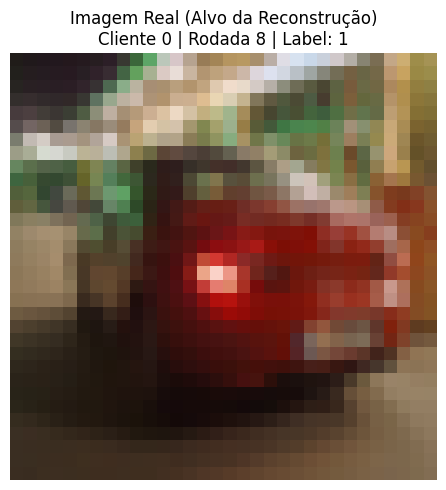


✓ Preparação para ataque DLG completa!
✓ Dados disponíveis:
   - attack_gradients: Gradientes da imagem (COMPLETOS)
   - intercepted_initial: Pesos iniciais do modelo
   - real_image: Imagem alvo (1, 3, 32, 32)
   - real_label: Label da imagem

✓ Ataque será executado em gradientes de precisão completa (baseline)


In [26]:
import random
import matplotlib.pyplot as plt
import logging


logging.basicConfig(level=logging.ERROR)

# ========== SELEÇÃO DO ALVO ==========
print(f"{'='*60}")
print("SELEÇÃO DE ALVO PARA ATAQUE DLG")
print(f"{'='*60}")

if not servidor.intercepted_quantized_gradients:
    print("❌ Erro: Nenhum gradiente interceptado!")
else:
    # Escolher alvo aleatório
    available_targets = list(servidor.intercepted_quantized_gradients.keys())
    target_idx = random.randint(0, len(available_targets)-1)
    TARGET_ROUND, TARGET_CLIENT = available_targets[target_idx]
    
    print(f"✓ Total de gradientes interceptados: {len(servidor.intercepted_quantized_gradients)}")
    print(f"✓ Alvos disponíveis: {available_targets[:5]}..." if len(available_targets) > 5 else f"✓ Alvos disponíveis: {available_targets}")
    print(f"\n🎯 Alvo selecionado:")
    print(f"   - Cliente: {TARGET_CLIENT}")
    print(f"   - Rodada: {TARGET_ROUND}")
    
    # ========== OBTER GRADIENTES INTERCEPTADOS (de 1 imagem) ==========
    intercepted_gradients = servidor.intercepted_quantized_gradients[(TARGET_ROUND, TARGET_CLIENT)]
    intercepted_metadata = servidor.intercepted_metadata[(TARGET_ROUND, TARGET_CLIENT)]
    
    print(f"\n📊 Gradientes interceptados (de 1 imagem):")
    print(f"   - Gradientes: {len(intercepted_gradients)} tensores")
    
    if ENABLE_QUANTIZATION and intercepted_metadata is not None:
        print(f"   - Status: QUANTIZADOS ({intercepted_metadata['num_bits']} bits)")
        print(f"   - Metadata: min={intercepted_metadata['min']:.4f}, max={intercepted_metadata['max']:.4f}")
        
        # Converter quantizados para float (mas mantendo valores discretizados)
        attack_gradients = [g.float() for g in intercepted_gradients if g is not None]
        
        # Estatísticas dos gradientes QUANTIZADOS
        grad_mins = [g.min().item() for g in attack_gradients]
        grad_maxs = [g.max().item() for g in attack_gradients]
        grad_uniques = [len(torch.unique(g)) for g in attack_gradients]
        
        print(f"\n⚠️  Atacante usando gradientes QUANTIZADOS (medida defensiva)")
        print(f"   - Range quantizado: [{min(grad_mins):.2f}, {max(grad_maxs):.2f}]")
        print(f"   - Valores únicos (primeiros 3 tensores): {grad_uniques[:3]}")
        print(f"   - Informação perdida pela quantização!")
    else:
        attack_gradients = [g.float() for g in intercepted_gradients if g is not None]
        print(f"\n✓ Sem quantização - gradientes em precisão completa (baseline)")
        
        # Estatísticas dos gradientes
        grad_mins = [g.min().item() for g in attack_gradients]
        grad_maxs = [g.max().item() for g in attack_gradients]
        print(f"   - Range dos gradientes: [{min(grad_mins):.6f}, {max(grad_maxs):.6f}]")
    
    # ========== OBTER PESOS INICIAIS INTERCEPTADOS ==========
    intercepted_initial = servidor.intercepted_initial_weights[(TARGET_ROUND, TARGET_CLIENT)]
    intercepted_initial_meta = servidor.intercepted_initial_metadata[(TARGET_ROUND, TARGET_CLIENT)]
    
    print(f"\n📦 Pesos iniciais interceptados: {len(intercepted_initial)} tensores")
    if ENABLE_QUANTIZATION and intercepted_initial_meta is not None:
        print(f"   - Status: QUANTIZADOS")
        print(f"   - Serão dequantizados para carregar no modelo")
    
    # ========== OBTER PESOS FINAIS (para referência) ==========
    intercepted_weights = servidor.intercepted_weights[(TARGET_ROUND, TARGET_CLIENT)]
    print(f"\n📦 Pesos finais também disponíveis: {len(intercepted_weights)} tensores")
    
    # ========== CRIAR CLIENTE PARA ACESSAR IMAGEM REAL ==========
    print(f"\n🔍 Carregando dados reais do cliente alvo...")
    target_client = ClienteComQuantizacao(
        TARGET_CLIENT, 
        NIID, 
        NCLIENTS, 
        DIRICHLET_ALPHA,
        quantizer=quantizer if ENABLE_QUANTIZATION else None
    )
    
    # ========== PEGAR A PRIMEIRA IMAGEM (que gerou os gradientes) ==========
    # Os gradientes capturados são da PRIMEIRA IMAGEM do primeiro batch
    real_image = torch.FloatTensor(target_client.x_train[0:1])  # (1, 3, 32, 32)
    real_label = torch.LongTensor([target_client.y_train[0]])    # (1,)
    
    print(f"✓ Imagem real carregada (primeira imagem do dataset):")
    print(f"   - Shape: {real_image.shape}")
    print(f"   - Label: {real_label.item()}")
    print(f"   - Min/Max valores: [{real_image.min():.3f}, {real_image.max():.3f}]")
    
    # ========== VISUALIZAR IMAGEM ALVO ==========
    plt.figure(figsize=(5, 5))
    img_display = real_image[0].permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    plt.title(f'Imagem Real (Alvo da Reconstrução)\nCliente {TARGET_CLIENT} | Rodada {TARGET_ROUND} | Label: {real_label.item()}', 
              fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print("✓ Preparação para ataque DLG completa!")
    print(f"✓ Dados disponíveis:")
    print(f"   - attack_gradients: Gradientes da imagem ({'QUANTIZADOS' if ENABLE_QUANTIZATION else 'COMPLETOS'})")
    print(f"   - intercepted_initial: Pesos iniciais do modelo")
    print(f"   - real_image: Imagem alvo (1, 3, 32, 32)")
    print(f"   - real_label: Label da imagem")
    if ENABLE_QUANTIZATION:
        print(f"\n⚠️  Ataque será executado em gradientes QUANTIZADOS")
        print(f"   (testando quantização como defesa)")
    else:
        print(f"\n✓ Ataque será executado em gradientes de precisão completa (baseline)")
    print(f"{'='*60}")

In [27]:
import torch.nn.functional as F
import logging

# Suprimir logs de debug
logging.getLogger('urllib3').setLevel(logging.ERROR)
logging.getLogger('datasets').setLevel(logging.ERROR)
logging.getLogger('huggingface_hub').setLevel(logging.ERROR)

print(f"{'='*60}")
print("PREPARAÇÃO DO MODELO E GRADIENTES GROUND TRUTH")
print(f"{'='*60}")

# ========== CRIAR MODELO ==========
modelo = utils.cria_modelo('cifar10')
modelo.eval()

# ========== CARREGAR PESOS INICIAIS INTERCEPTADOS ==========
print(f"\n📥 Carregando pesos INICIAIS interceptados no modelo...")

if ENABLE_QUANTIZATION and intercepted_initial_meta is not None:
    # Dequantizar pesos iniciais para carregar no modelo
    print(f"   - Dequantizando pesos iniciais...")
    dequantized_initial = quantizer.dequantize_gradients(intercepted_initial, intercepted_initial_meta)
    
    params_dict = zip(modelo.state_dict().keys(), dequantized_initial)
    state_dict = {k: v.clone() if isinstance(v, torch.Tensor) else torch.tensor(v) for k, v in params_dict}
else:
    # Sem quantização
    params_dict = zip(modelo.state_dict().keys(), intercepted_initial)
    state_dict = {k: v.clone() if isinstance(v, torch.Tensor) else torch.tensor(v) for k, v in params_dict}

modelo.load_state_dict(state_dict, strict=True)
print(f"✓ Modelo carregado com pesos INICIAIS da rodada {TARGET_ROUND}")
print(f"   (Pesos ANTES do treinamento - mesmos usados para calcular os gradientes)")

# ========== HABILITAR GRADIENTES ==========
for param in modelo.parameters():
    param.requires_grad = True

# ========== COMPUTAR GRADIENTES GROUND TRUTH ==========
print(f"\n🎯 Computando gradientes ground truth (precisão completa)...")

# Criar one-hot label
label_onehot = torch.nn.functional.one_hot(real_label, num_classes=10).float()

# Forward pass com a imagem real
output_modelo = modelo(real_image)

# Loss
criterion = utils.cross_entropy_for_onehot
loss = criterion(output_modelo, label_onehot)

# Backward para calcular gradientes
gradientes = torch.autograd.grad(loss, modelo.parameters(), create_graph=False)
gradientes_ground_truth = [g.detach().clone() for g in gradientes]

print(f"✓ Gradientes ground truth calculados: {len(gradientes_ground_truth)} tensores")
print(f"✓ Primeiro gradiente shape: {gradientes_ground_truth[0].shape}")
print(f"✓ Range: min={gradientes_ground_truth[0].min():.6f}, max={gradientes_ground_truth[0].max():.6f}")

# ========== COMPARAÇÃO: Gradientes Interceptados vs Ground Truth ==========
print(f"\n📊 Comparação dos gradientes:")

if ENABLE_QUANTIZATION:
    print(f"\n   1️⃣ Gradientes INTERCEPTADOS (atacante possui):")
    print(f"      - Tipo: QUANTIZADOS ({intercepted_metadata['num_bits']} bits)")
    print(f"      - Valores discretos de 0 a {2**intercepted_metadata['num_bits']-1}")
    print(f"      - Informação perdida pela quantização")
    
    print(f"\n   2️⃣ Gradientes GROUND TRUTH (referência):")
    print(f"      - Tipo: Precisão completa float32")
    print(f"      - Usados para avaliar qualidade da reconstrução")
    
    # Dequantizar gradientes interceptados para comparação
    print(f"\n   3️⃣ Comparação (dequantizando interceptados):")
    dequantized_grads = quantizer.dequantize_gradients(intercepted_gradients, intercepted_metadata)
    
    diff_norms = []
    for g_deq, g_gt in zip(dequantized_grads, gradientes_ground_truth):
        diff = torch.norm(g_deq - g_gt).item()
        norm_gt = torch.norm(g_gt).item()
        diff_norms.append(diff / (norm_gt + 1e-8))
    
    avg_relative_error = np.mean(diff_norms)
    print(f"      - Erro relativo médio: {avg_relative_error:.4f}")
    print(f"      - Erro causado pela quantização")
    
else:
    # Baseline sem quantização
    print(f"\n   1️⃣ Gradientes INTERCEPTADOS:")
    print(f"      - Tipo: Precisão completa float32")
    
    print(f"\n   2️⃣ Gradientes GROUND TRUTH:")
    print(f"      - Tipo: Precisão completa float32")
    
    # Comparar diretamente
    print(f"\n   3️⃣ Comparação:")
    diff_norms = []
    for g_int, g_gt in zip(attack_gradients, gradientes_ground_truth):
        diff = torch.norm(g_int - g_gt).item()
        norm_gt = torch.norm(g_gt).item()
        diff_norms.append(diff / (norm_gt + 1e-8))
    
    avg_relative_error = np.mean(diff_norms)
    print(f"      - Erro relativo médio: {avg_relative_error:.6f}")
    if avg_relative_error < 1e-5:
        print(f"      ✓ Gradientes praticamente idênticos (esperado no baseline)")
    else:
        print(f"      ⚠️ Diferença significativa - pode haver problema!")

print(f"\n{'='*60}")
print("✓ Modelo e gradientes prontos para ataque DLG!")
print(f"{'='*60}")

# ========== RESUMO DOS DADOS ==========
print(f"\n📋 Resumo dos dados para o ataque:")
print(f"   - modelo: LeNet carregado com pesos INICIAIS")
print(f"   - attack_gradients: {len(attack_gradients)} tensores ({'QUANTIZADOS' if ENABLE_QUANTIZATION else 'COMPLETOS'})")
print(f"   - gradientes_ground_truth: {len(gradientes_ground_truth)} tensores (referência)")
print(f"   - real_image: {real_image.shape}")
print(f"   - real_label: {real_label.item()}")
print(f"   - criterion: cross_entropy_for_onehot")

PREPARAÇÃO DO MODELO E GRADIENTES GROUND TRUTH

📥 Carregando pesos INICIAIS interceptados no modelo...
✓ Modelo carregado com pesos INICIAIS da rodada 8
   (Pesos ANTES do treinamento - mesmos usados para calcular os gradientes)

🎯 Computando gradientes ground truth (precisão completa)...
✓ Gradientes ground truth calculados: 10 tensores
✓ Primeiro gradiente shape: torch.Size([12, 3, 5, 5])
✓ Range: min=-0.118200, max=0.142170

📊 Comparação dos gradientes:

   1️⃣ Gradientes INTERCEPTADOS:
      - Tipo: Precisão completa float32

   2️⃣ Gradientes GROUND TRUTH:
      - Tipo: Precisão completa float32

   3️⃣ Comparação:
      - Erro relativo médio: 0.000001
      ✓ Gradientes praticamente idênticos (esperado no baseline)

✓ Modelo e gradientes prontos para ataque DLG!

📋 Resumo dos dados para o ataque:
   - modelo: LeNet carregado com pesos INICIAIS
   - attack_gradients: 10 tensores (COMPLETOS)
   - gradientes_ground_truth: 10 tensores (referência)
   - real_image: torch.Size([1, 3, 3

## 3. Implementar Ataque DLG

EXECUÇÃO DO ATAQUE DLG

🎲 Criando imagem e label dummy (inicialização aleatória)...
✓ Imagem dummy criada: torch.Size([1, 3, 32, 32])
✓ Label dummy criado: torch.Size([1, 10])

📊 Comparação: Real vs Inicial (ruído)


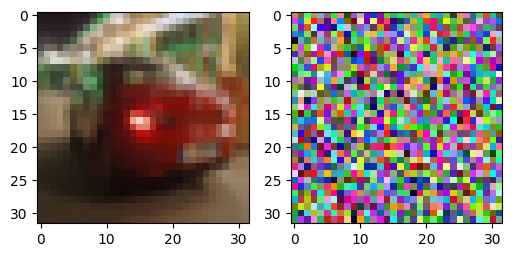


⚙️  Configurando otimizador LBFGS...
✓ Otimizador configurado

🚀 Iniciando ataque DLG...
   - Tipo de gradientes: PRECISÃO COMPLETA (baseline)
   - Número de iterações: 300
   - Algoritmo: DLG (Deep Leakage from Gradients)
   - Otimizador: LBFGS


🔧 Invertendo Gradientes...: 100%|██████████| 300/300 [00:45<00:00,  6.64it/s, loss_inversao=1.1518e-06]



✓ Ataque completo!
✓ 30 snapshots salvos durante a otimização

📊 Resultado final do ataque:


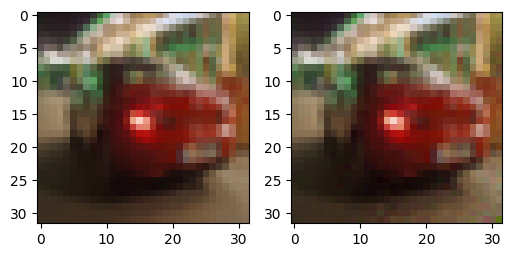


📈 Métricas de qualidade da reconstrução:
   - MSE: 0.000110
   - PSNR: 39.57 dB
   - SSIM: (não disponível - instale scikit-image)

🏷️  Label:
   - Real: 1
   - Reconstruído: 1
   ✓ Label correto!

✓ Ataque executado sobre gradientes COMPLETOS (baseline)
   Qualidade esperada: ALTA
   → Vulnerabilidade sem proteção!


In [28]:
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms

print(f"{'='*60}")
print("EXECUÇÃO DO ATAQUE DLG")
print(f"{'='*60}")

# ========== CRIAR DADOS DUMMY (inicialização aleatória) ==========
print(f"\n🎲 Criando imagem e label dummy (inicialização aleatória)...")

# Label one-hot para uma única imagem
label_onehot = torch.nn.functional.one_hot(real_label, num_classes=10).float()

# Criar ruído para UMA IMAGEM
imagem_fake, label_fake = utils.cria_ruido(real_image.size(), label_onehot.size())

print(f"✓ Imagem dummy criada: {imagem_fake.shape}")
print(f"✓ Label dummy criado: {label_fake.shape}")

# ========== VISUALIZAR COMPARAÇÃO INICIAL ==========
print(f"\n📊 Comparação: Real vs Inicial (ruído)")
utils.compara_imagens(real_image, imagem_fake)

# ========== CONFIGURAR OPTIMIZER ==========
print(f"\n⚙️  Configurando otimizador LBFGS...")
optimizer_dlg = torch.optim.LBFGS([imagem_fake, label_fake])
print(f"✓ Otimizador configurado")

# ========== FUNÇÃO DE ATAQUE ==========
def run_ataque(modelo, imagem_fake, label_fake, gradientes_alvo,
               optimizer, criterion, ataque='dlg', num_iterations=300):
    """
    Executa ataque DLG para reconstruir imagem a partir de gradientes
    
    Args:
        modelo: Modelo com pesos INICIAIS
        imagem_fake: Imagem dummy a ser otimizada
        label_fake: Label dummy a ser otimizado
        gradientes_alvo: Gradientes interceptados (QUANTIZADOS ou completos)
        optimizer: Otimizador LBFGS
        criterion: Função de perda
        ataque: 'dlg' ou 'idlg'
        num_iterations: Número de iterações
    
    Returns:
        history: Lista de snapshots da imagem durante otimização
    """
    history = []
    to_pilimage = transforms.ToPILImage()
    loop = tqdm(range(num_iterations), desc=f"🔧 Invertendo Gradientes...")
    
    for iters in loop:
        def closure():
            optimizer.zero_grad()
            pred_ataque = modelo(imagem_fake)
            
            if ataque == 'dlg':
                # DLG: otimizar também o label
                onehot_ataque = F.softmax(label_fake, dim=-1)
            elif ataque == 'idlg':
                # iDLG: inferir label dos gradientes (última camada)
                onehot_ataque = torch.argmin(
                    torch.sum(gradientes_alvo[-2], dim=-1), 
                    dim=-1
                ).detach().reshape((1,)).requires_grad_(False)
            
            # Calcular loss e gradientes da imagem dummy
            loss_ataque = criterion(pred_ataque, onehot_ataque)
            gradientes_ataque = torch.autograd.grad(
                loss_ataque, 
                modelo.parameters(),
                create_graph=True
            )
            
            # Calcular diferença entre gradientes reconstruídos e alvo
            grad_diff = 0
            for gx, gy in zip(gradientes_ataque, gradientes_alvo):
                grad_diff += ((gx - gy) ** 2).sum()
            
            grad_diff.backward()
            return grad_diff
        
        optimizer.step(closure)
        current_loss = closure().item()
        loop.set_postfix(loss_inversao=f"{current_loss:.4e}")
        
        # Salvar snapshot periodicamente
        if iters % 10 == 0:
            history.append(to_pilimage(imagem_fake[0].cpu()))
    
    return history

# ========== EXECUTAR ATAQUE ==========
print(f"\n🚀 Iniciando ataque DLG...")
print(f"   - Tipo de gradientes: {'QUANTIZADOS (' + str(intercepted_metadata['num_bits']) + ' bits)' if ENABLE_QUANTIZATION else 'PRECISÃO COMPLETA (baseline)'}")
print(f"   - Número de iterações: 300")
print(f"   - Algoritmo: DLG (Deep Leakage from Gradients)")
print(f"   - Otimizador: LBFGS")

# Usar gradientes interceptados (quantizados ou não)
history = run_ataque(
    modelo, 
    imagem_fake, 
    label_fake, 
    attack_gradients,  # Gradientes interceptados (quantizados!)
    optimizer_dlg, 
    criterion=utils.cross_entropy_for_onehot, 
    ataque='dlg', 
    num_iterations=300
)

print(f"\n✓ Ataque completo!")
print(f"✓ {len(history)} snapshots salvos durante a otimização")

# ========== VISUALIZAR RESULTADO FINAL ==========
print(f"\n📊 Resultado final do ataque:")
utils.compara_imagens(real_image, imagem_fake)

# ========== CALCULAR MÉTRICAS DE QUALIDADE ==========
print(f"\n📈 Métricas de qualidade da reconstrução:")

# MSE
mse = torch.mean((real_image - imagem_fake.detach()) ** 2).item()
print(f"   - MSE: {mse:.6f}")

# PSNR
if mse > 0:
    psnr = 10 * np.log10(1.0 / mse)
    print(f"   - PSNR: {psnr:.2f} dB")
else:
    print(f"   - PSNR: Infinito (reconstrução perfeita)")

# SSIM (se tiver a biblioteca)
try:
    from skimage.metrics import structural_similarity as ssim
    img_real_np = real_image[0].permute(1, 2, 0).detach().numpy()
    img_fake_np = imagem_fake[0].permute(1, 2, 0).detach().numpy()
    ssim_value = ssim(img_real_np, img_fake_np, multichannel=True, data_range=1.0, channel_axis=2)
    print(f"   - SSIM: {ssim_value:.4f}")
except:
    print(f"   - SSIM: (não disponível - instale scikit-image)")

# Label reconstruído
label_reconstruido = torch.argmax(label_fake).item()
print(f"\n🏷️  Label:")
print(f"   - Real: {real_label.item()}")
print(f"   - Reconstruído: {label_reconstruido}")
if label_reconstruido == real_label.item():
    print(f"   ✓ Label correto!")
else:
    print(f"   ✗ Label incorreto")

print(f"\n{'='*60}")
if ENABLE_QUANTIZATION:
    print("⚠️  Ataque executado sobre gradientes QUANTIZADOS")
    print(f"   Qualidade esperada: DEGRADADA")
    print(f"   → Quantização funcionou como defesa!")
else:
    print("✓ Ataque executado sobre gradientes COMPLETOS (baseline)")
    print(f"   Qualidade esperada: ALTA")
    print(f"   → Vulnerabilidade sem proteção!")
print(f"{'='*60}")

## 5. Visualizar Resultados do Ataque

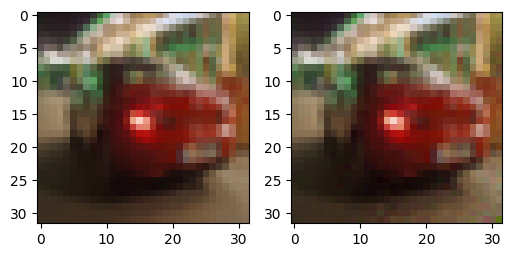


Label real: 1
Label reconstruído: 1
Match: ✓


(ClientAppActor pid=38865) /usr/local/Cellar/python@3.12/3.12.0/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(ClientAppActor pid=38865)   warnings.warn('resource_tracker: There appear to be %d '


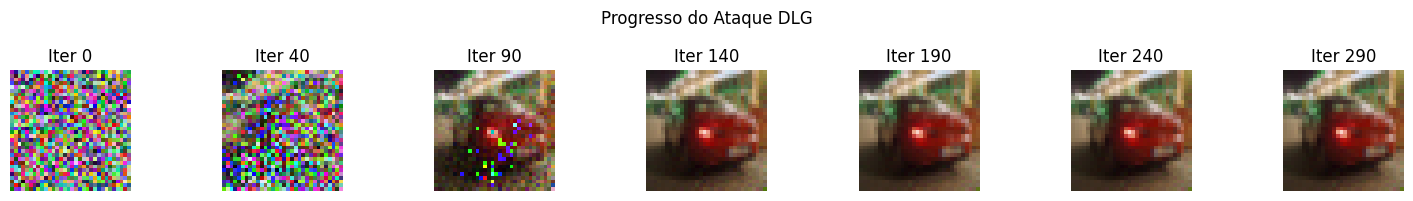

In [29]:
# Comparação final
utils.compara_imagens(real_image, imagem_fake)

# Label reconstruído
label_reconstruido = torch.argmax(label_fake, dim=-1).item()
print(f"\nLabel real: {real_label.item()}")
print(f"Label reconstruído: {label_reconstruido}")
print(f"Match: {'✓' if label_reconstruido == real_label.item() else '✗'}")

# Plot histórico
num_snapshots = min(7, len(history))
indices = np.linspace(0, len(history)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(1, num_snapshots, figsize=(15, 2))
for idx, hist_idx in enumerate(indices):
    axes[idx].imshow(history[hist_idx])
    axes[idx].axis('off')
    axes[idx].set_title(f'Iter {hist_idx*10}')

plt.suptitle('Progresso do Ataque DLG')
plt.tight_layout()
plt.show()

---
## Visualização de Performance FL (Original)

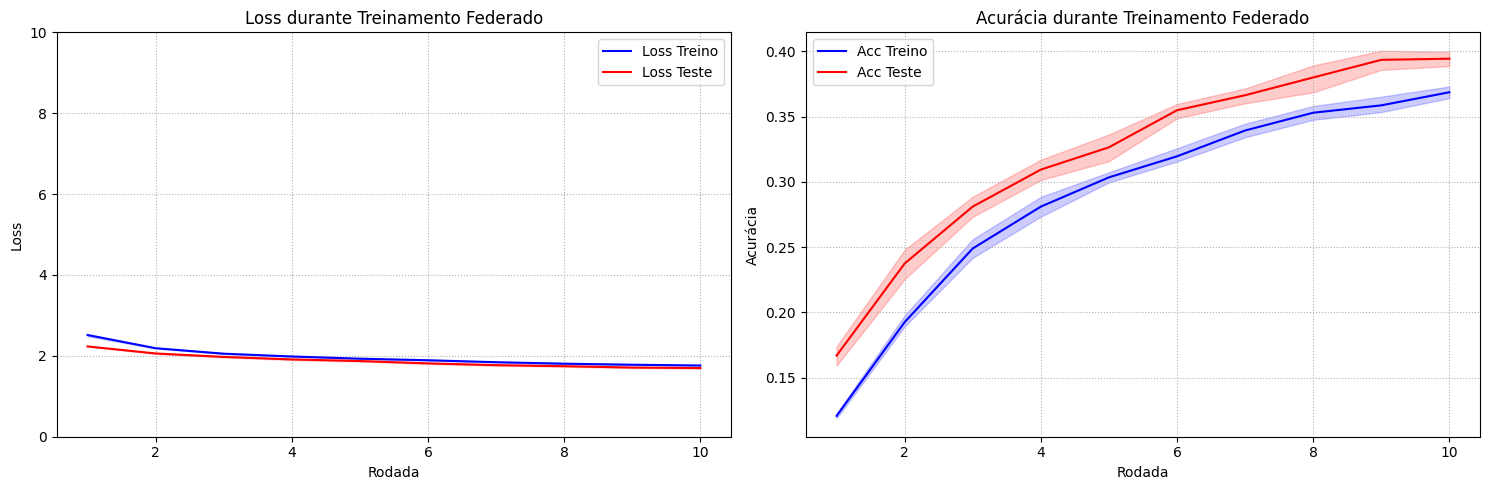

In [30]:
import pandas as pd
import seaborn as sns

try:
    df_train = pd.read_csv('train.csv', names=['server_round', 'cid', 'acc', 'loss'])
    df_test  = pd.read_csv('evaluate.csv', names=['server_round', 'cid', 'acc', 'loss'])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(data=df_train, x='server_round', y='loss', ax=ax[0], color='b', label='Loss Treino')
    sns.lineplot(data=df_test, x='server_round', y='loss', ax=ax[0], color='r', label='Loss Teste')
    ax[0].set_ylim(0, 10)  # <<< limita o eixo Y
    ax[0].set_title('Loss durante Treinamento Federado')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Rodada')
    ax[0].legend()
    ax[0].grid(True, linestyle=':')

    sns.lineplot(data=df_train, x='server_round', y='acc', ax=ax[1], color='b', label='Acc Treino')
    sns.lineplot(data=df_test, x='server_round', y='acc', ax=ax[1], color='r', label='Acc Teste')
    ax[1].set_title('Acurácia durante Treinamento Federado')
    ax[1].set_ylabel('Acurácia')
    ax[1].set_xlabel('Rodada')
    ax[1].legend()
    ax[1].grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print("Arquivos de log não encontrados. Execute a simulação primeiro.")